# Instalacja zależności:

In [1]:
%pip install segmentation-models-pytorch lightning albumentations
%pip install onnx

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
#WCZYTANIE DANYCH

In [3]:
import os
import cv2

import torch
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torch.optim import lr_scheduler
import segmentation_models_pytorch as smp
import pytorch_lightning as pl


/home/maciej_br/ZPO/projekt_obrazy/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/maciej_br/ZPO/projekt_obrazy/.venv/lib/python3.11/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
from pytorch_lightning.callbacks import ModelCheckpoint
import onnx

checkpoint_callback = ModelCheckpoint(
    monitor='valid_dataset_iou',   # metryka do monitorowania (dostosuj nazwę do swojej konfiguracji)
    dirpath='checkpoints/',      # katalog zapisu checkpointów
    filename='best-checkpoint',  # nazwa pliku checkpointu
    save_top_k=1,                # zapisuj tylko najlepszy model
    mode='max'                   # 'max' dla metryk, które mają być maksymalizowane
)

In [5]:
#PODZIAŁ DANYCH
DATA_DIR = "./data/png/"

x_train_dir = os.path.join(DATA_DIR, "train")
y_train_dir = os.path.join(DATA_DIR, "trainannot")

x_valid_dir = os.path.join(DATA_DIR, "valid")
y_valid_dir = os.path.join(DATA_DIR, "validannot")

x_test_dir = os.path.join(DATA_DIR, "test")
y_test_dir = os.path.join(DATA_DIR, "testannot")

In [6]:
class Dataset(BaseDataset):

    CLASSES = [
        "background",
        "bicycle-crossing",
        "pedestrian-crossing",
    ]

    def __init__(self, images_dir, masks_dir, classes=None, augmentation=None):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id.rstrip('.png')+'_mask.png') for image_id in self.ids]
        
        self.background_class = self.CLASSES.index("background")
        
        if classes:
            self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        else:
            self.class_values = list(range(len(self.CLASSES)))  # Default to all classes

   
            
        self.class_map = {self.background_class: 0}
        current_label = 1
        
        for v in self.class_values:
            if v != self.background_class:
                self.class_map[v] = current_label
                current_label += 1
                
        # self.class_map.update(
        #     {
        #         v: i + 1
        #         for i, v in enumerate(self.class_values)
        #         if v != self.background_class
        #     }
        # )

        self.augmentation = augmentation

    # def __getitem__(self, i):
    #     image = cv2.imread(self.images_fps[i])
    #     # BGR-->RGB
    #     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #     mask = cv2.imread(self.masks_fps[i], 0)

    #     # Create a blank mask to remap the class values
    #     mask_remap = np.zeros_like(mask)
        
    #     # # extract certain classes from mask (e.g. cars)
    #     # masks = [(mask == v) for v in self.class_values]
    #     # mask = np.stack(masks, axis=-1).astype("flo1:1669249152
    #     # print(f"Unique labels after remapping: {unique_labels}")

    #     # apply augmentations
    #     # if self.augmentation:
    #     #     sample = self.augmentation(image=image, mask=mask)
    #     #     image, mask = sample["image"], sample["mask"]

    #     # return image.transpose(2, 0, 1), mask.transpose(2, 0, 1)
    #     image = image.transpose(2, 0, 1)
    #     return image, mask_remap
    
    def __getitem__(self, i):
    # Wczytaj obraz
        # Wczytaj obraz
        image = cv2.imread(self.images_fps[i])
        if image is None:
            print(f"Nie udało się wczytać obrazu: {self.images_fps[i]}")
            image = np.zeros((512, 512, 3), dtype=np.uint8)
        else:
            # Konwersja BGR->RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image.astype(np.float32) / 255.0

        # Wczytaj maskę w odcieniach szarości
        mask = cv2.imread(self.masks_fps[i], 0)
        if mask is None:
            print(f"Nie udało się wczytać maski: {self.masks_fps[i]}")
            mask = np.zeros((512, 512), dtype=np.uint8)

        # Ujednolicenie rozmiaru obrazu i maski (opcjonalnie)
        target_size = (512, 512)  # ustaw docelowy rozmiar
        image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

        # Remapowanie klasy w masce
        mask_remap = np.zeros_like(mask)
        for class_value, new_value in self.class_map.items():
            mask_remap[mask == class_value] = new_value

        image = image.transpose(2, 0, 1)

        # Zwracamy dane jako tablice NumPy
        return image, mask_remap

    def __len__(self):
        return len(self.ids)

In [7]:

def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(" ".join(name.split("_")).title())

        # If it's an image, plot it as RGB
        if name == "image":
            # Convert CHW to HWC for plotting
            image = image.transpose(1, 2, 0)
            plt.imshow(image)
        else:
            plt.imshow(image, cmap="tab20")
    plt.show()


Mask shape: (512, 512)


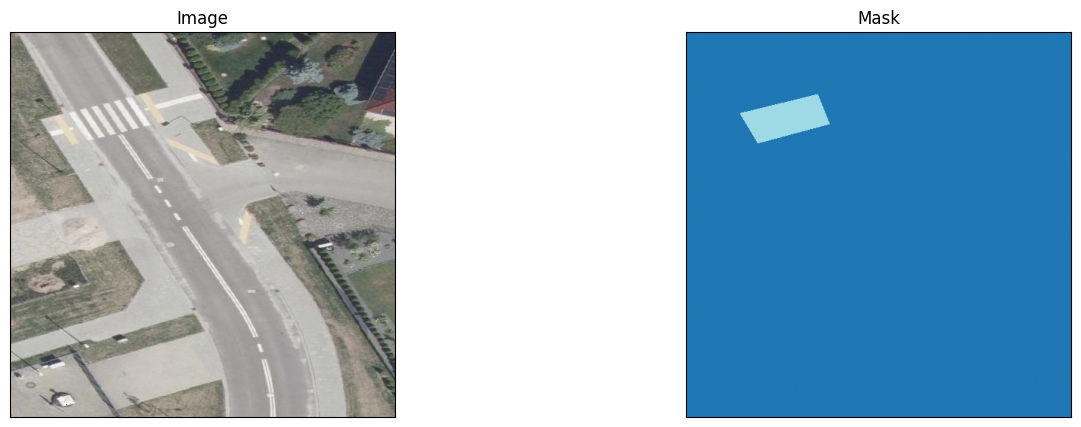

In [8]:

dataset = Dataset(x_train_dir, y_train_dir)
image, mask = dataset[0]
print(f"Mask shape: {mask.shape}")
visualize(image=image, mask=mask)

In [9]:
# CLASSES = [
#     "background",
#     "bicycle-crossing",
#     "pedestrian-crossing",
# ]

train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=None,
    # classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    augmentation=None,
    # classes=CLASSES,
)

test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    augmentation=None,
    # classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)


In [10]:
EPOCHS = 50
T_MAX = EPOCHS * len(train_loader)
OUT_CLASSES = 3

In [11]:
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torch
from torch.optim import lr_scheduler


class CamVidModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )

        # Preprocessing parameters for image normalization
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.number_of_classes = out_classes
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))
        print(self.std)
        print(self.mean)

        # Loss function for multi-class segmentation
        self.loss_fn = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True)

        # Step metrics tracking
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # Normalize image
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image, mask = batch

        # Ensure that image dimensions are correct
        assert image.ndim == 4  # [batch_size, channels, H, W]

        # Ensure the mask is a long (index) tensor
        mask = mask.long()

        # Mask shape
        assert mask.ndim == 3  # [batch_size, H, W]

        # Predict mask logits
        logits_mask = self.forward(image)

        assert (
            logits_mask.shape[1] == self.number_of_classes
        )  # [batch_size, number_of_classes, H, W]

        # Ensure the logits mask is contiguous
        logits_mask = logits_mask.contiguous()

        # Compute loss using multi-class Dice loss (pass original mask, not one-hot encoded)
        loss = self.loss_fn(logits_mask, mask)

        # Apply softmax to get probabilities for multi-class segmentation
        prob_mask = logits_mask.softmax(dim=1)

        # Convert probabilities to predicted class labels
        pred_mask = prob_mask.argmax(dim=1)

        # Compute true positives, false positives, false negatives, and true negatives
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask, mask, mode="multiclass", num_classes=self.number_of_classes
        )

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # Aggregate step metrics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # Per-image IoU and dataset IoU calculations
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        self.training_step_outputs.clear()

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        self.test_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }

In [12]:
model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)

tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]])
tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]])


In [13]:
trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1, callbacks=[checkpoint_callback])

trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/maciej_br/ZPO/projekt_obrazy/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_preci

Epoch 49: 100%|██████████| 97/97 [00:44<00:00,  2.19it/s, v_num=95, valid_per_image_iou=0.987, valid_dataset_iou=0.987, train_per_image_iou=0.995, train_dataset_iou=0.995]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 97/97 [00:44<00:00,  2.19it/s, v_num=95, valid_per_image_iou=0.987, valid_dataset_iou=0.987, train_per_image_iou=0.995, train_dataset_iou=0.995]


In [14]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_loader, verbose=False)
print(valid_metrics)

# run test dataset
test_metrics = trainer.test(model, dataloaders=test_loader, verbose=False)
print(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 28/28 [00:03<00:00,  7.12it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[{'valid_per_image_iou': 0.9871888160705566, 'valid_dataset_iou': 0.9871286749839783}]
Testing DataLoader 0: 100%|██████████| 14/14 [00:01<00:00,  7.34it/s]
[{'test_per_image_iou': 0.9874452948570251, 'test_dataset_iou': 0.987375020980835}]


In [15]:
# Załaduj najlepszy model
best_model_path = checkpoint_callback.best_model_path
print(f"Najlepszy model zapisany w: {best_model_path}")
trained_model = CamVidModel.load_from_checkpoint(
    best_model_path,
    arch="FPN",
    encoder_name="resnext50_32x4d",
    in_channels=3,
    out_classes=OUT_CLASSES
).model

# Eksport do ONNX
trained_model.cpu()
trained_model.eval()
dummy_input = torch.randn(1, 3, 512, 512, device='cpu')
_ = trained_model(dummy_input)
torch.onnx.export(
    trained_model,
    dummy_input,
    "camvid_model.onnx",
    export_params=True,
    opset_version=15,
    do_constant_folding=False,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'},  # variable lenght axes
                              'output': {0: 'batch_size'}}
)
print("Wytrenowany model został wyeksportowany do formatu ONNX jako 'camvid_model.onnx'.")

onnx_model = onnx.load("camvid_model.onnx")
onnx.checker.check_model(onnx_model)
print("Model ONNX jest poprawny!")

Najlepszy model zapisany w: /home/maciej_br/ZPO/projekt_obrazy/checkpoints/best-checkpoint-v12.ckpt
tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]])
tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]])


/home/maciej_br/ZPO/projekt_obrazy/.venv/lib/python3.11/site-packages/segmentation_models_pytorch/base/model.py:17: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if h % output_stride != 0 or w % output_stride != 0:


Wytrenowany model został wyeksportowany do formatu ONNX jako 'camvid_model.onnx'.
Model ONNX jest poprawny!


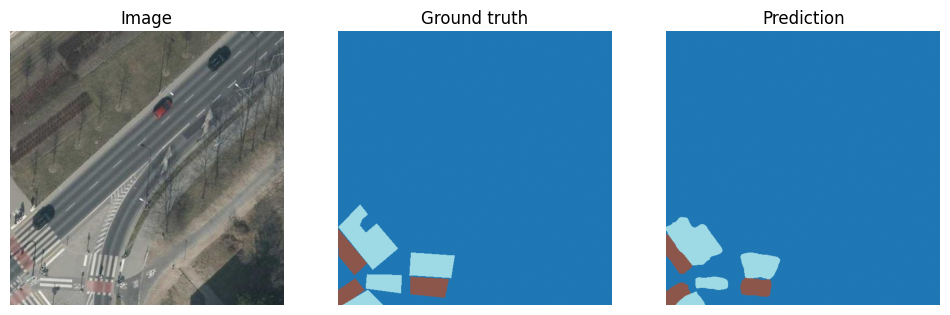

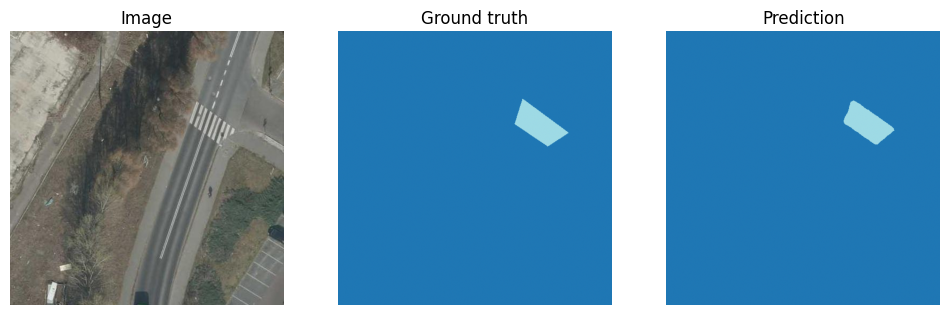

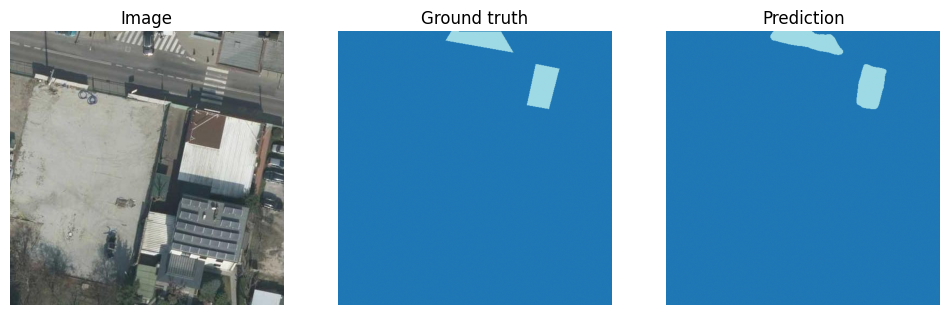

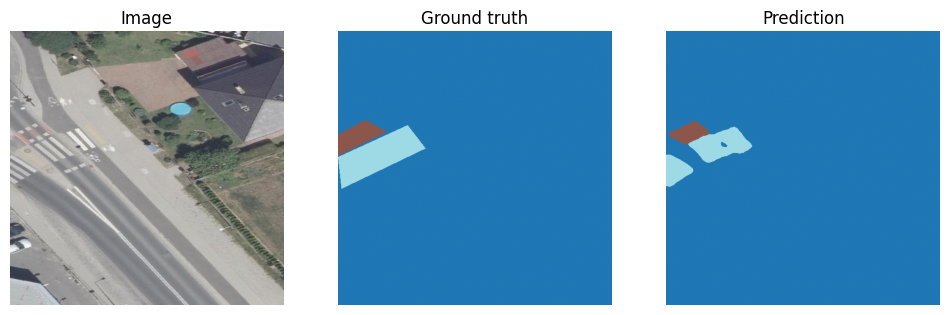

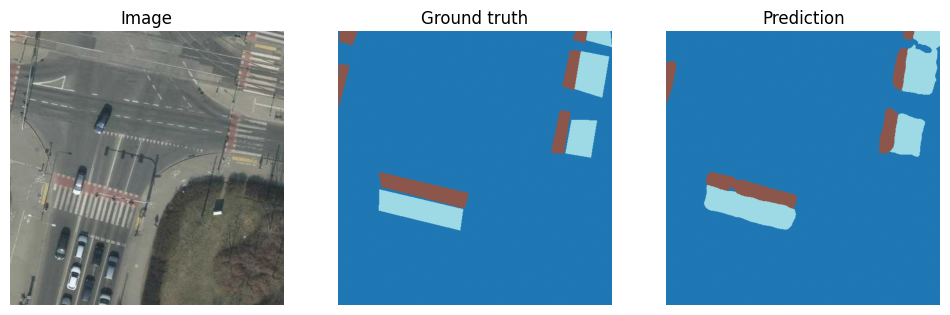

In [16]:
import numpy as np

# Fetch a batch from the test loader
images, masks = next(iter(test_loader))

# Switch the model to evaluation mode
with torch.no_grad():
    model.eval()
    logits = model(images)  # Get raw logits from the model

# Apply softmax to get class probabilities
# Shape: [batch_size, num_classes, H, W]

pr_masks = logits.softmax(dim=1)
# Convert class probabilities to predicted class labels
pr_masks = pr_masks.argmax(dim=1)  # Shape: [batch_size, H, W]

# Visualize a few samples (image, ground truth mask, and predicted mask)
for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
    if idx <= 4:  # Visualize first 5 samples
        plt.figure(figsize=(12, 6))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(
            image.cpu().numpy().transpose(1, 2, 0)
        )  # Convert CHW to HWC for plotting
        plt.title("Image")
        plt.axis("off")

        # Ground Truth Mask
        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.cpu().numpy(), cmap="tab20")  # Visualize ground truth mask
        plt.title("Ground truth")
        plt.axis("off")

        # Predicted Mask
        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.cpu().numpy(), cmap="tab20")  # Visualize predicted mask
        plt.title("Prediction")
        plt.axis("off")

        # Show the figure
        plt.show()
    else:
        break

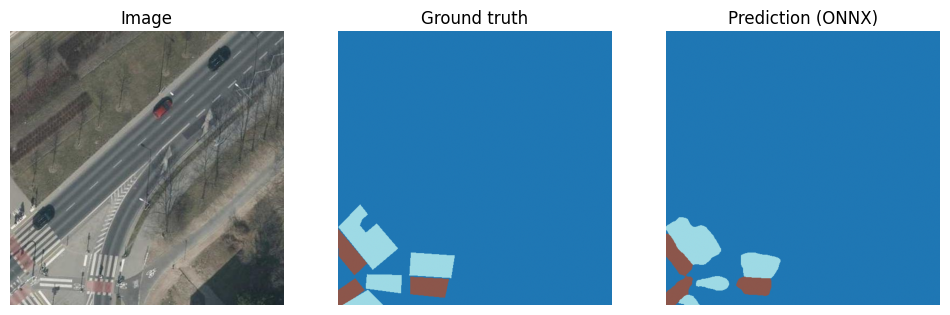

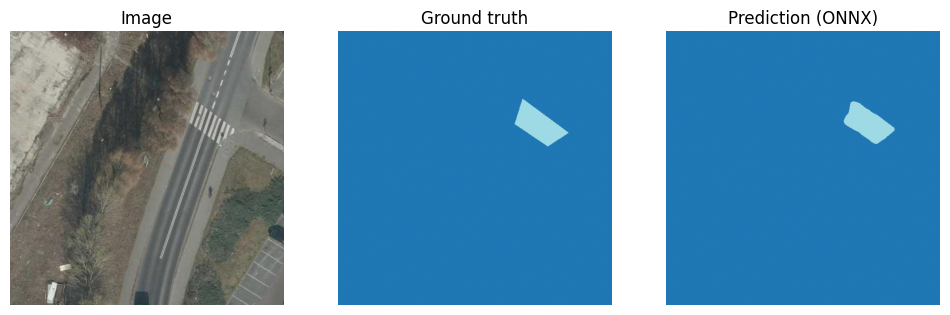

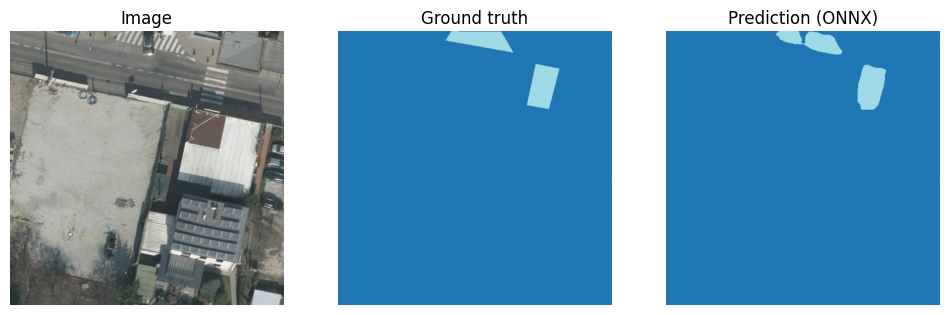

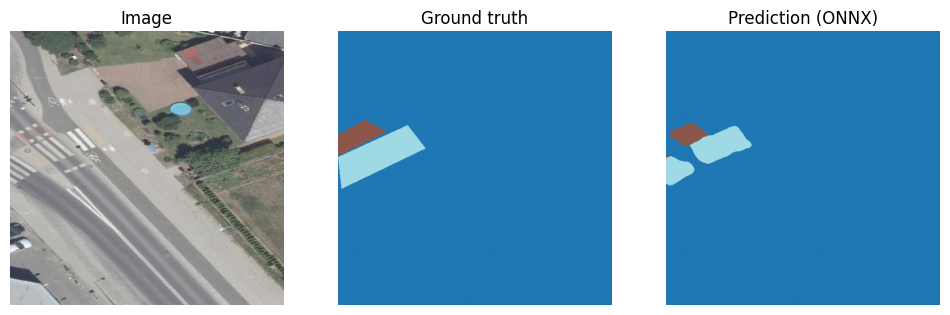

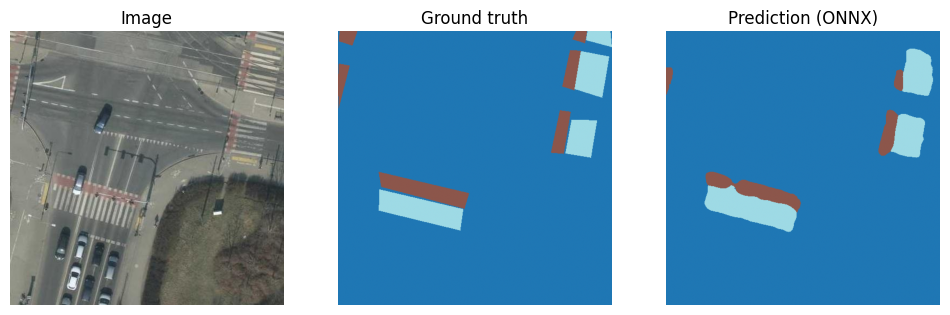

In [17]:
import onnxruntime as ort
import numpy as np
import matplotlib.pyplot as plt

# Załaduj model ONNX
session = ort.InferenceSession("camvid_model.onnx")
input_name = session.get_inputs()[0].name

# Pobierz batch z test_loader
images, masks = next(iter(test_loader))
images = images.cpu()
# Konwertuj dane wejściowe do float32
images_np = images.numpy().astype(np.float32)
images_np = images_np[:8]
# Przygotuj wejście dla modelu ONNX
ort_inputs = {input_name: images_np}

# Wykonaj inferencję
ort_outs = session.run(None, ort_inputs)
logits = ort_outs[0]  # Uzyskaj surowe logity

# Oblicz softmax i argmax, aby uzyskać przewidywane maski
exp_logits = np.exp(logits)
sum_exp = np.sum(exp_logits, axis=1, keepdims=True)
prob_masks = exp_logits / sum_exp
pred_masks = np.argmax(logits, axis=1)  # kształt: [batch_size, H, W]

# Wizualizacja wyników
for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pred_masks)):
    if idx <= 4:
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy(), cmap="tab20")
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask, cmap="tab20")
        plt.title("Prediction (ONNX)")
        plt.axis("off")



In [18]:
import json
import onnx

model = onnx.load('camvid_model.onnx')

class_names = {
    0: 'background',
    1: "bicycle-crossing_",
    2: "pedestrian-crossing_",

}

# model.metadata_props.remove('model_type')
m1 = model.metadata_props.add()
m1.key = 'model_type'
m1.value = json.dumps('Segmentor')

# model.metadata_props.remove('class_names')
m2 = model.metadata_props.add()
m2.key = 'class_names'
m2.value = json.dumps(class_names)

# model.metadata_props.remove('resolution')
# m3 = model.metadata_props.add()
# m3.key = 'resolution'
# m3.value = json.dumps(10)

# optional, if you want to standarize input after normalisation
# model.metadata_props.update({'standardization_mean': json.dumps([0.4850, 0.4560, 0.4060])}) 
# model.metadata_props.remove('standardization_mean')
m4 = model.metadata_props.add()
m4.key = 'standardization_mean'
m4.value = json.dumps([0.4850, 0.4560, 0.4060])

# model.metadata_props.remove('standardization_std')
m5 = model.metadata_props.add()
m5.key = 'standardization_std'
m5.value = json.dumps([0.2290, 0.2240, 0.2250])

onnx.save(model, 'camvid_model.onnx')